In [1]:
import pandas as pd 
from pandas import Series
import numpy as np 
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.api import qqplot  
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson


from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX 

import pmdarima as pm
from pmdarima import auto_arima 
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import nsdiffs
from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn import datasets

# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 

In [2]:
#Importing data
Shanghai = pd.read_csv("D:/Math546 Time series/final projects/PM2.5 Data of Five Chinese Cities Data Set/ShanghaiPM20100101_20151231.csv")


In [3]:
#Delet non-useful data
##Beijing.drop(['PM_Dongsi', 'PM_Dongsihuan', 'PM_Nongzhanguan', 'season', 'precipitation', 'Iprec'], 
##               axis=1,
##              inplace=True)

In [4]:
Shanghai.dropna(axis=0, how="any",inplace=True)

In [5]:
# from datetime import datetime
Shanghai['Time'] = pd.to_datetime(Shanghai['year'].map(str) +"/"+ Shanghai['month'].map(str) +"/"+ Shanghai['day'].map(str)+" "+Shanghai['hour'].map(str)+":00:00")
#Beijing

In [6]:
Shanghai.groupby(['year']).size()

year
2013    7276
2014    7311
2015    6849
dtype: int64

In [7]:
by_hour = Shanghai.groupby(['Time']).mean()
#by_hour.head()

In [8]:
by_hour.index = pd.to_datetime(by_hour.index, 
                             format='%d-%m-%Y %H:%M:%S')
by_hour = by_hour.set_index(by_hour.index).asfreq('H')
by_hour = by_hour.fillna(method='ffill')

#print(by_hour.index)

In [9]:
by_hour['Time'] = by_hour.index
#by_hour['Time']

In [10]:
data_13 = by_hour[(by_hour['Time'] >=pd.to_datetime('20130101030000')) & (by_hour['Time'] <= pd.to_datetime('20150101030000'))]

In [11]:
data_13 = data_13.set_index(data_13.index).asfreq('d')
data_13 = data_13.fillna(method='ffill')
#data_13

In [13]:
data = by_hour[(by_hour['Time'] >=pd.to_datetime('20130101030000')) & (by_hour['Time'] <= pd.to_datetime('20130201030000'))]
data = data.set_index(data.index).asfreq('d')
data = data.fillna(method='ffill')
#data

In [14]:
#data_13.to_csv(r'D:/Math546 Time series/project/Prep_FiveCitiePMData_MEAN/ShanghaiPM_cleaned.csv')

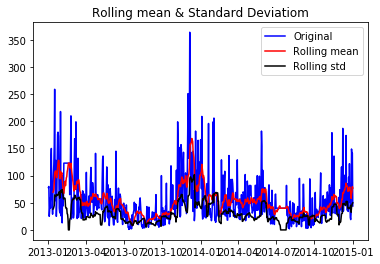

Resluts of Dickey-Fuller Test:
Test Statistic                 -3.436944
p-value                         0.009762
#lags used                     14.000000
Number of obervations used    716.000000
Critical Value(1%)             -3.439516
Critical Value(5%)             -2.865585
Critical Value(10%)            -2.568924
dtype: float64


In [15]:
# take aDFuller test the statioinarity of  the timeseries
def test_stationarity(timeseries):
 #Determing rolling statistics
    rolmean=pd.Series.rolling(timeseries,window=12).mean()
 #rolmean=pd.rolling_mean(timeseries,window=12)
 #rolstd=pd.rolling_std(timeseries,window=12)
    rolstd=pd.Series.rolling(timeseries,window=12).std()
 
 #plot rolling statistics
    orig=plt.plot(timeseries,color='blue',label='Original')
    mean=plt.plot(rolmean,color='red',label='Rolling mean')
    std=plt.plot(rolstd,color='black',label='Rolling std')
    plt.legend(loc='best')
    plt.title('Rolling mean & Standard Deviatiom')
    plt.show(block=False)
 
 #perfprmance Dickey_Fuller Test
    print('Resluts of Dickey-Fuller Test:')
    dftest=adfuller(timeseries,autolag='AIC')
    dfountput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','Number of obervations used'])
 
    for key,value in dftest[4].items():
        dfountput['Critical Value(%s)'%key]=value      
    print(dfountput)
# 

test_stationarity(data_13['PM_US Post'])

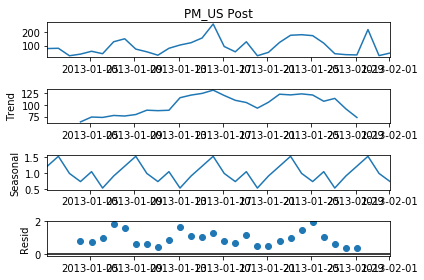

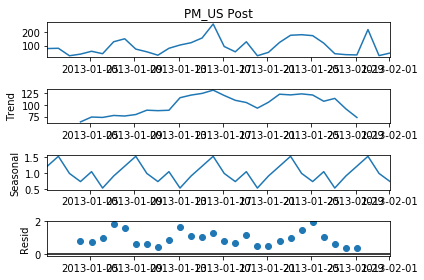

In [16]:
result = seasonal_decompose(data['PM_US Post'],  
                            model ='multiplicative') 
  
# ETS plot  
result.plot()

In [17]:
len(data_13)

731

In [18]:
# Split data into train / test sets 
train = data_13['PM_US Post'].iloc[:len(data_13)-156] 
test = data_13['PM_US Post'].iloc[len(data_13)-156:]

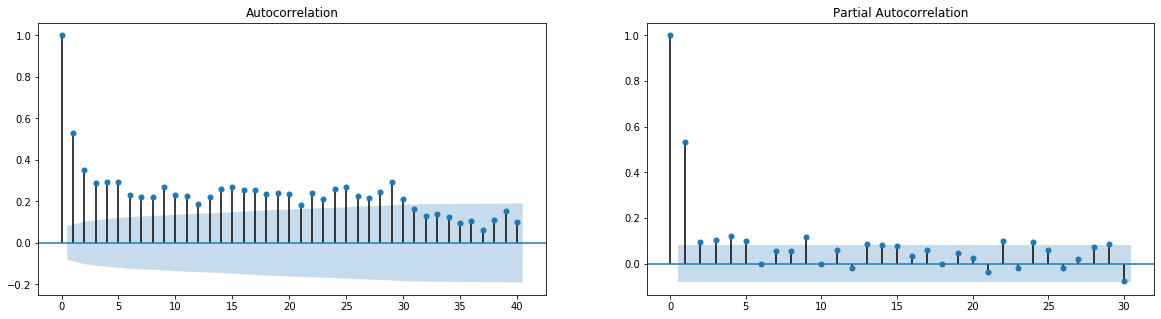

In [19]:
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig, axes = plt.subplots(1,2, figsize=(20,5))
plot_acf(train, lags=40, ax=axes[0], fft=False)
plot_pacf(train, lags=30, ax=axes[1])
plt.show()

In [28]:
# Fit auto_arima function to dataset 
stepwise_fit = auto_arima(train, start_p = 0, start_q = 0, 
                          max_p = 4, max_q = 4, m=52,
                          start_P = 0, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise  

Performing stepwise search to minimize aic
Fit ARIMA: (0, 0, 0)x(0, 1, 1, 52) (constant=True); AIC=5635.928, BIC=5648.707, Time=30.137 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 52) (constant=True); AIC=5827.514, BIC=5836.033, Time=0.765 seconds
Fit ARIMA: (1, 0, 0)x(1, 1, 0, 52) (constant=True); AIC=5537.227, BIC=5554.266, Time=26.103 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 1, 52) (constant=True); AIC=5507.438, BIC=5524.477, Time=64.474 seconds
Near non-invertible roots for order (0, 0, 1)(0, 1, 1, 52); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 52) (constant=False); AIC=5829.855, BIC=5834.114, Time=0.530 seconds
Fit ARIMA: (1, 0, 0)x(0, 1, 0, 52) (constant=True); AIC=5675.923, BIC=5688.701, Time=6.233 seconds
Fit ARIMA: (1, 0, 0)x(2, 1, 0, 52) (constant=True); AIC=5506.991, BIC=5528.289, Time=93.421 seconds
Fit ARIMA: (1, 0, 0)x(2, 1, 1, 52) (constant=True); AIC=5460.570, BIC=5486.128, Time=290.569 seconds

In [29]:
# To print the summary 
stepwise_fit.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  575
Model:             SARIMAX(4, 0, 1)x(2, 1, 1, 52)   Log Likelihood               -2705.960
Date:                            Tue, 14 Apr 2020   AIC                           5431.920
Time:                                    21:29:15   BIC                           5474.516
Sample:                                         0   HQIC                          5448.603
                                            - 575                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0252      0.037     -0.679      0.497      -0.098       0.047
ar.L1          1.3465      0.045     29.877      0.000       1.258       1.435
ar.L2         -0.3840      0.058     -6.573      0.000      -0.498      -0.269
ar.L3          0.0109      0.065      0.167      0.867      -0.116       0.138
ar.L4          0.0171      0.042      0.410      0.682      -0.065       0.099
ma.L1         -0.9180      0.027    -34.019      0.000      -0.971      -0.865
ar.S.L52       0.0164      0.083      0.197      0.844      -0.147       0.180
ar.S.L104      0.0784      0.082      0.957      0.339      -0.082       0.239
ma.S.L52      -0.9867      1.110     -0.889      0.374      -3.161       1.188
sigma2      1481.0425   1532.405      0.966      0.334   -1522.417    4484.502
===================================================================================
Ljung-Box (Q):                       54.76   Jarque-Bera (JB):               391.94
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                             1.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
# Fit a SARIMAX(4, 0, 1)x(2, 1, 1, 52)on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model = SARIMAX(train,  
                order = (4, 0, 1),  
                seasonal_order =(2, 1, 1, 52))

In [31]:
result = model.fit() 

In [32]:
 result.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         PM_US Post   No. Observations:                  575
Model:             SARIMAX(4, 0, 1)x(2, 1, 1, 52)   Log Likelihood               -2706.294
Date:                            Tue, 14 Apr 2020   AIC                           5430.588
Time:                                    21:36:23   BIC                           5468.924
Sample:                                01-01-2013   HQIC                          5445.602
                                     - 07-29-2014                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3470      0.043     31.090      0.000       1.262       1.432
ar.L2         -0.3840      0.058     -6.663      0.000      -0.497      -0.271
ar.L3          0.0112      0.064      0.174      0.862      -0.115       0.137
ar.L4          0.0171      0.041      0.412      0.680      -0.064       0.098
ma.L1         -0.9171      0.026    -34.839      0.000      -0.969      -0.866
ar.S.L52       0.0061      0.083      0.073      0.942      -0.156       0.169
ar.S.L104      0.0718      0.081      0.885      0.376      -0.087       0.231
ma.S.L52      -0.9326      0.218     -4.282      0.000      -1.359      -0.506
sigma2      1549.7127    228.724      6.775      0.000    1101.422    1998.004
===================================================================================
Ljung-Box (Q):                       54.84   Jarque-Bera (JB):               381.07
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                             1.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

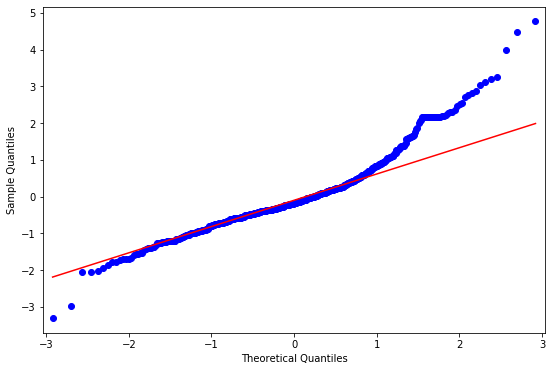

In [33]:
resid = result.resid
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
qqplot(resid, line='q', ax=ax, fit=True)
plt.show()

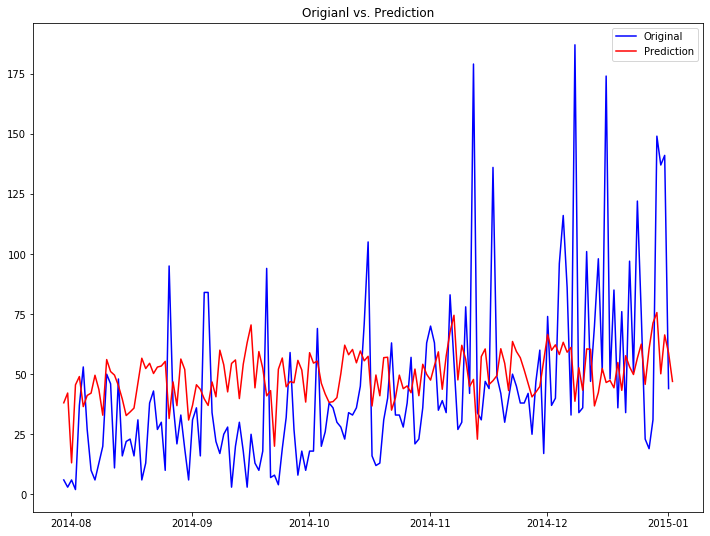

In [34]:
predict_ARMA = result.predict(start =575, end = 731) 
#print(predict_ARIMA) 

plt.figure(figsize=(12,9)) 
orig = plt.plot(test, color='blue', label='Original') 
pred = plt.plot(predict_ARMA, color='red', label='Prediction' ) 
plt.legend(loc='best') 
plt.title('Origianl vs. Prediction') 
plt.show(block=False) 